
<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
   
                                          
                                          
                                          
                                          
                                          
#                                                 Regression with Abalone Data Set: Generalized Additive Models (GAMs)




#                                                        Gladys Murage

#                              College of Business, Engineering, and  Technology, National University

#                                         DDS8555 v1: PREDICTIVE ANALYSIS(3602869492)

#                                                        Dr MOHAMED NABEEL

#                                                            March 28, 2025


<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
<BR>

# Overview of the Generalized Additive Model (GAM) on the Abalone Dataset
The following algorithm  builds a Generalized Additive Model (GAM) using the pygam library from Python to predict Rings the target variable based on features like Whole weight, Sex, and others from the Abalone dataset obtained from Kaggle.com. The algorithm pipeline starts by loading libraries and data,  processes the data, trains a GAM, evaluates performance using RMSLE (Root Mean Squared Logarithmic Error), and creates a submission file for a Kaggle competition. Additionally, it generates visualizations to interpret the effects of different features. Specifically in the end a visualization of Whole weight a predictor variable versus the target variable ( number of Rings) is obtained.


100% (11 of 11) |########################| Elapsed Time: 0:09:52 Time:  0:09:520:54


Validation RMSLE: 0.1601


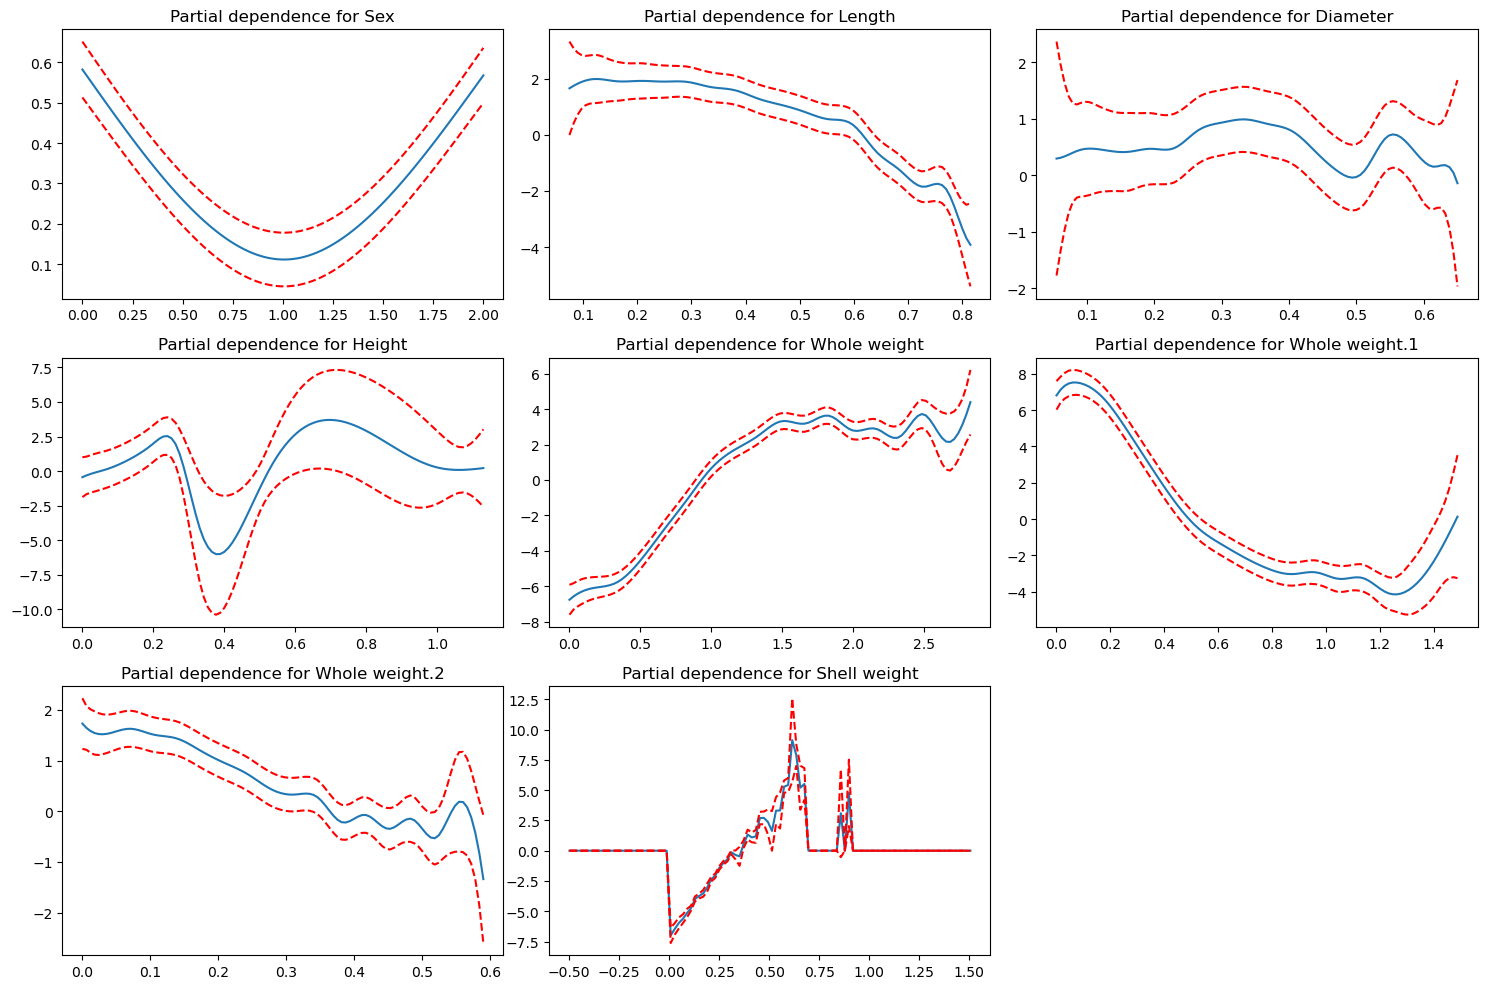

Submission8 file created successfully!


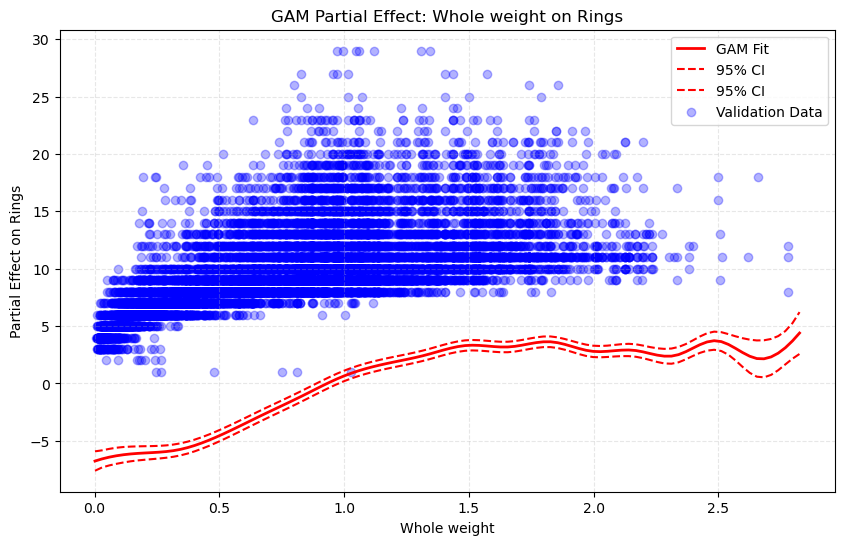


Model Summary:
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    471.1099
Link Function:                     IdentityLink Log Likelihood:                               -167897.7696
Number of Samples:                        72492 AIC:                                           336739.7591
                                                AICc:                                          336745.9619
                                                GCV:                                                3.5516
                                                Scale:                                                3.51
                                                Pseudo R-Squared:                                   0.6527
Feature Function     

/tmp/ipykernel_9086/1871787969.py:122: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [5]:
# Import libraries
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f  # s() for smoothing splines, f() for categorical factors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

# Load the datasets
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Data preprocessing
def preprocess_data(df):
    # Convert Sex to categorical codes
    df['Sex'] = df['Sex'].astype('category').cat.codes
    
    # Handle potential missing values (if any)
    df.fillna(df.mean(), inplace=True)
    
    return df

# Preprocess both train and test data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Split train data into features and target
X = train_data.drop(['id', 'Rings'], axis=1)
y = train_data['Rings']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit the GAM model
# Using smoothing terms for continuous variables and factor term for Sex
gam = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7),  # 7 continuous vars + 1 categorical
    fit_intercept=True
)

# Fit the model
gam.gridsearch(X_train.values, y_train.values)

# Predict on validation set
y_pred = gam.predict(X_val.values)

# Calculate RMSLE
# Since RMSLE requires positive values, we clip predictions to a small positive number
y_pred_clipped = np.clip(y_pred, a_min=1e-10, a_max=None)
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred_clipped))
print(f"Validation RMSLE: {rmsle:.4f}")

# Plot partial dependence plots to understand feature contributions
plt.figure(figsize=(15, 10))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    
    plt.subplot(3, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    
    feature_name = X.columns[i]
    plt.title(f"Partial dependence for {feature_name}")
    
plt.tight_layout()
plt.savefig('sex.png', dpi=300, bbox_inches='tight')
plt.savefig('length.png', dpi=300, bbox_inches='tight')
plt.savefig('diameter.png', dpi=300, bbox_inches='tight')
plt.savefig('height.png', dpi=300, bbox_inches='tight')
plt.savefig('Whole_weight.png', dpi=300, bbox_inches='tight')
plt.savefig('Whole_weight.1.png', dpi=300, bbox_inches='tight')
plt.savefig('Whole_weight.2.png', dpi=300, bbox_inches='tight')
plt.savefig('Shell_weight.1.png', dpi=300, bbox_inches='tight')
plt.show()

# Prepare test data predictions
X_test = test_data.drop('id', axis=1)
test_pred = gam.predict(X_test.values)

# Clip predictions to be positive (required for RMSLE)
test_pred = np.clip(test_pred, a_min=1, a_max=None)  # Abalones must have at least 1 ring

# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'Rings': test_pred
})

# Save submission file
submission.to_csv('submission8.csv', index=False)
print("Submission8 file created successfully!")

# Select a single feature to visualize (for example, the first non-categorical feature)
feature_idx = 4  # You can change this to visualize different features
feature_name = X.columns[feature_idx]

# Create a grid for plotting
XX = gam.generate_X_grid(term=feature_idx)
predictions = gam.partial_dependence(term=feature_idx, X=XX)
confidence = gam.partial_dependence(term=feature_idx, X=XX, width=.95)[1]


# Plot the feature effect with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(XX[:, feature_idx], predictions, color="red", linewidth=2, label="GAM Fit")
plt.plot(XX[:, feature_idx], confidence, c='r', ls='--', label="95% CI")
plt.scatter(X_val.iloc[:, feature_idx], y_val, color="blue", alpha=0.3, label="Validation Data")
plt.xlabel(feature_name)
plt.ylabel("Partial Effect on Rings")
plt.title(f"GAM Partial Effect: {feature_name} on Rings")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.savefig('AbaloneGAM.png', dpi=300, bbox_inches='tight')
plt.show()


# Display model summary
print("\nModel Summary:")
print(gam.summary())

# A. Interpretation of RMSLE (0.1601) in GAM Regression for the Abalone Dataset
The Root Mean Squared Log Error (RMSLE) is a metric used to evaluate regression models, particularly when predicting positive, right-skewed targets such as  the number of rings in abalones. The key  RMSLE  properties are:

1. Penalizes underestimates more than overestimates which is useful for predicting counts like age of an abalone.

2. Scale-independent: This means that it Works well for targets spanning multiple orders of magnitude.

# What does RMSLE of  0.1601 Mean?
Ideally the RMSLE should be as close to zero as possible. Nevertheless for this Kaggle competition, I have head to head regression models conducted on the same Abalone data to conduct a comparative study to. Previous RMSLE for previous regression models are as follows:
#### Linear Regression RMSLE =  0.1668
#### Validation RMSLE (Random Forest): 0.15567026949474086
#### Validation RMSLE (XGBoost): 0.1531
#### Validation RMSLE (Best XGBoost Model): 0.1521
#### Validation RMSLE (Log-Transformed Target, XGBoost): 0.1514
#### RMSLE on validation set: 0.20025094970075333 for PCA on linear regression
#### Root Mean Squared Logarithmic Error on Validation Set: 0.20534378215404459 for Elastic Net( L1 and L2 regression combined)
#### Validation RMSLE: 0.1948 with Cubic Spline using 2 knots
#### Validation RMSLE: 0.1601 with GAM

# Interpretation of RMSLE of 0.1601 GAM?
From previous regression model algorithms that I have conducted on the abalone dataset , the RMSLE of 0.1601 is less than than the basic linear regression model. Secondly, it i worth noting that it is the lowest RMSLE for non-linear regression models compared to elastic net, PCA and Cubic Spline. Third, it is worth noting that the RMSLE of 0.1601 does not beat, and is larger than that of ensemble algorithms namely Random forest and Extreme Gradient Boost (XGBOOST). Ensemble machine learning methods combine multiple models to achieve better RMSLE in this case than any single model on its own. 

# Practical Implications
On average, the GAM model’s log-predictions deviate from the true log-values by ±0.1601. This means that for true rigns predicted to be 10, the GAM model  predicts between 7.4 to 13.5 rings. This suggests moderate error in predicting 7 rings for a 10-ring abalone. It calls for improvement of the model.

A GAM model was used because GAMs capture nonlinear relationships such as  shell weight vs. rings and furthermore, partial dependence plots discussed below show curved trends, justifying the use of splines in the GAM model.

# Next steps: Improvement of the GAM model
#### 1. Adjust Smoothing Parameters:
This can be achieved by increasing the number of splines or tune lambda (smoothing penalty) in LinearGAM.

#### 2. Feature Engineering
This can be achieved two fold by doing the following 
##### a. Log-Transform Skewed Features:
If Shell Weight is right-skewed, try np.log(Shell Weight).

##### b  New Features
Use of ratios such as  Height / Diameter) or use of polynomial terms.

 #### Alternative Models
XGBoost/LightGBM: Often outperform GAMs on tabular data.As shown in the head to head competition above XGBOOST log transformed target had the lowest RMSLE so far at 0.1514 versus 0.1601 of GAM.

Use of ensemble: Combine GAM with a tree-based model. It is worth noting that in the head to head competition Random forest out performed GAM in RMSLE by 0.1557 to 0.1601.

# B. Interpretation of the partial dependence plots (PDPs) for each feature in the GAM regression model for the Abalone dataset. 

PDPs show how each feature influences the predicted number of Rings (age) while marginalizing over other features.

#### 1. Sex (Categorical)
The y-axis shows the relative contribution to predicted Rings. 0 = Infant, 1 = Female, 2 = Male (after categorical encoding).

Trend: infants (0) have the lowest predicted Rings (youngest),females (1) and males (2) contribute similarly but slightly more than Infants.

Conclusion: Sex has a modest effect, with adults both female and male having more rings than infants.

#### 2. Height
Nonlinear relationship with very low or high heights reduce predicted Rings. There is a peak around 0.2–0.4 units (optimal height for ring growth).
Possible Reason is that extremely low heights may indicate young abalones. Conversely, very high heights could correlate with abnormal growth which is not proportional to age.

#### 3. Whole Weight
A positive trend exists, the higher the  weight the more the rings meaning older abalones. The curves flatten at higher weights showing diminishing returns.
This is a key Insight that shows that weight is a strong predictor of age, but not perfectly linear.

#### 4. Length
The length rapidly increases, then plateaus with a sharp rise in rings up to ~0.4 units, and it then stabilizes.
The implication is that length matters most for younger abalones but is  less predictive for older ones.

#### 5. Diameter
It is similar to length but more smoother. This implies that diameter and length are biologically correlated. Peak contribution is noted  around 0.3–0.5 units. Also worth noting is that smaller diameters predict fewer rings meaning that these are younger abalones.

#### 6. Shell Weight
This is the strongest predictor which shows a steady increase in rings with increase shell weight. Importantly, there is no plateau observed, unlike in Whole Weight. This is an interesting key insight, which can b explained biologically by the fact that shell weight directly reflects cumulative growth which is represented by the number of rings.

# Key Takeaways
#### Top Features:
1. Shell weight and Whole eight are the most influential features showing monotonic increase.

2. Height/Length/Diameter have nonlinear effects showing optimal mid-range values.

3. Sex has a minor but clear effect.

#### Nonlinearities:
The GAM regression captures curved relationships such as the Height’s "hump" shape. This finding therefore  suggests physical growth is not linear with age.

# Actionable Insights:
In order to improve the model, one should focus on Shell weight for model improvement. Feature engineering with engineer interaction ratios such as Shell Weight / Diameter to capture growth ratios.

# Potential Issues
1. To check for Overfitting? Check if confidence intervals (dashed lines) are wide.
2. Feature Correlations: If Length/Diameter/Weight are highly correlated, consider PCA or regularization.

# C. Breakdown of GAM model summary and its key components:

#### 1. Model Overview
There is normal distribution. The GAM model assumes that the target (Rings) follows a normal distribution.
Link Function: IdentityLink. Meaning that predictions are linear combinations of features without transformation.
Log Likelihood: -167,897.77. This is the measure of model fit. A higher measure is better and is used to compute AIC.
Number of Samples: 72,492 which is the size of the training dataset.

#### 2. Model Performance Metrics
###### AIC	336,739.76. Lower AIC is better and is used for model selection by penalizes complexity.
###### AICc 336,745.96. This represents AIC corrected for small samples. in this case it is similar to AIC.
###### GCV	3.5516. This is the Generalized Cross-Validation score and a lower number shows a better fit.
###### Scale 3.51. This is the estimated variance of residuals.
###### Pseudo R². 0.6527. This means that approximately 65% of variance in Rings (age of abalones) is explained by the model. While this is a decent value, it does leave a lot of room to improve.

#### 3. Feature Analysis
Each feature is modeled with s(), Which is smoothing spline for continuous features and f() which is a factor term for categorical Sex.

#### 4. Key Columns:
###### Lambda	[0.0631] . Smoothing penalty. Higher lambda shows that I have a  Less flexible spline.
###### Rank	20. This is the number of basis functions used for the spline.
###### EDoF	3.1–372.6. Effective Degrees of Freedom. Higher df gives more complex feature effect.
###### P > x	1.11e-16. p-value is below 0.0001 and is statistically significant however read warnings below.
###### Sig. Code	***	.Extremely significant as evidenced by a p < 0.001.


#### 5 Notable Observations:
##### f(7) (Sex):
EDoF = 372.6. Meaning that three is presence of very high complexity. There is likely overfitting for the categorical variable. 3 categories of the young, Male and female  should not need need 372 EDoF). The solution is to reduce the number of splines or switch to a simpler encoding such as one-hot encoding.

##### Continuous Features (e.g., ShellWeight):

EDoF ~8–18. Nonlinear relationships shows that splines are flexible but not extreme. An example is s(6), Shell weight, has EDoF=17.9. This shows a strong nonlinear effect. 

##### Intercept. Shows fixed baseline prediction when all features are zero.

#### 6. Warnings Explained
Identifiability Problem. Fitting both splines and linear terms to the same feature can make p-values misleadingly significant in a GAM. The solution is to avoid mixing splines and linear terms for a single feature.

P-value reliability. P-values are too optimistic when smoothing parameters are estimated from data in a GAM. The solution is to treat p-values as rough guides, not as the absolute truth. It is recommended that cross-validation is used for feature importance.

#### Critical Takeaways
##### Strengths:
1. The GAM Model explains approximately 65% of variance which is a decent initial model before hyper-tuning and feature engineering.

2. The model captures nonlinear effects e.g.,the Shell weight which has a strong influence to the GAM mas a feature.

##### Weaknesses:
1. Overfitting risk. Extremely high EDoF for Sex (372.6).

2. Suspicious p-values: Treat significance with caution due to warnings in python.

#### Next Steps:
1. Simplify Sex feature and use the number of spline as 3, since Sex has 3 categories.
2. Cross-validate. Check to see if reduced complexity improves test performance.
3. Feature engineering. An attempt should be made at log-transforming skewed features such as weights.

### Summary
This GAM is complex but reasonably predictive, with clear signals from features like Shell weight. The Pythorn warnings suggest proceeding with caution when it comes to statistical significance, and the high EDoF for Sex indicates potential overfitting. Simplifying the model and focusing on robust validation will improve reliability.